In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RDKit installation

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [3]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [4]:
!conda install -c conda-forge rdkit

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

# RDKit load

In [5]:
import rdkit.Chem

# Read Data


---


reference: https://pubs.acs.org/doi/10.1021/acs.jcim.7b00083

* PubChemQC DB has ~221 millions TD-DFT calculation data of molecules (B3LYP/6-31G*)
* It contains the optimized molecular structures, HOMO-LUMO gap, and information about excitation state (oscillator strength, S1, S2, S3, ... energies)
* oscillator strength ~ absorption coefficient

Filename: PubchemQC_subset_HOMO-LUMO_and_OS.csv.bz2

* bz2 module documents: https://docs.python.org/3/library/bz2.html

In [6]:
import bz2
fin = bz2.open("PubchemQC_subset_HOMO-LUMO_and_OS.csv.bz2", "rt")   # "rt" indicates read / text

In [7]:
header = fin.readline()
print(header)

#Index,HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES



In [8]:
from tqdm import tqdm

gap_list = []
os_list = []
smi_list = []
ii = 0
max_mol = 100000      # due to memory limit, only 100,000 data will be sampled

for l in tqdm(fin):
  idx, gap, os, smi = l.strip().split(',')
  gap = float(gap)
  os = float(os)
  gap_list.append(gap)
  os_list.append(os)
  smi_list.append(smi)
  ii += 1
  if ii >= max_mol:
    break
  else:
    continue

99999it [00:00, 171376.24it/s]


In [9]:
print(len(gap_list))

100000


In [10]:
from rdkit.Chem import AllChem

# transform the molecules into ECFP from SMILES
X_ECFP = []
for smi in tqdm(smi_list):
  mol = rdkit.Chem.MolFromSmiles(smi)
  vec = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
  X_ECFP.append(vec.ToList())

100%|██████████| 100000/100000 [00:28<00:00, 3537.35it/s]


In [11]:
y = gap_list

In [12]:
import sklearn
from sklearn.model_selection import train_test_split

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_ECFP, y, test_size=0.2, shuffle=True)

# train/validate split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

In [13]:
import torch

# transfrom X and y into torch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [14]:
type(X_train)

torch.Tensor

In [15]:
from torch.utils.data import TensorDataset, DataLoader

# Dataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader
loader_train = DataLoader(ds_train, batch_size=1024, shuffle=True, drop_last=True)
loader_test = DataLoader(ds_test, batch_size=1024, shuffle=False)

In [16]:
print(len(loader_train.dataset))
print(len(loader_test.dataset))

72000
20000


In [19]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(1024, 128),     # input_dim = 1024
    nn.LeakyReLU(0.1),
    nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.LeakyReLU(0.1),
    nn.BatchNorm1d(64),
    nn.Linear(64, 32),
    nn.LeakyReLU(0.1),
    nn.BatchNorm1d(32),
    nn.Linear(32, 1)          # output_dim = 1
)

print(model)

Sequential(
  (0): Linear(in_features=1024, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.1)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): LeakyReLU(negative_slope=0.1)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.1)
  (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=32, out_features=1, bias=True)
)


In [20]:
from torch import optim

# loss function
loss_fn = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 1e-5)

In [21]:
def train(epoch, X_val, y_val):
  loss_list = []
  model.train()

  for data, targets in loader_train:

    optimizer.zero_grad()
    outputs = model(data)
    outputs = outputs[:,0]            # to make the shape of targets the same as outputs

    loss = loss_fn(outputs, targets)
    loss_list.append(loss.item())     # '.item()': save the values of loss, rather than the tensors themselves

    loss.backward()
    optimizer.step()

  val_loss = loss_fn(model(X_val)[:,0], y_val)
  print(f"epoch {epoch} // Loss: {loss:.5f} // Val_loss: {val_loss:.5f}")

  # return loss values at each epoch
  return loss.item(), val_loss.item()

In [26]:
def test():
  model.eval()
  mse = 0

  with torch.no_grad():
    for data, targets in loader_test:
      outputs = model(data)
      outputs = outputs[:,0]
      mse += torch.sum((outputs - targets)**2)

  mse /= len(loader_test.dataset)

  print(f'\n prediction accuracy with the test data: {mse:.3f} (eV)')

In [28]:
for epoch in range(100):
  train(epoch, X_val, y_val)

test()

epoch 0 // Loss: 0.04669 // Val_loss: 0.17172
epoch 1 // Loss: 0.03392 // Val_loss: 0.17126
epoch 2 // Loss: 0.02990 // Val_loss: 0.17861
epoch 3 // Loss: 0.03524 // Val_loss: 0.17341
epoch 4 // Loss: 0.03895 // Val_loss: 0.16956
epoch 5 // Loss: 0.04065 // Val_loss: 0.17709
epoch 6 // Loss: 0.04128 // Val_loss: 0.17677
epoch 7 // Loss: 0.05488 // Val_loss: 0.17314
epoch 8 // Loss: 0.03273 // Val_loss: 0.17114
epoch 9 // Loss: 0.03546 // Val_loss: 0.16835
epoch 10 // Loss: 0.03440 // Val_loss: 0.16899
epoch 11 // Loss: 0.03881 // Val_loss: 0.17204
epoch 12 // Loss: 0.04096 // Val_loss: 0.17869
epoch 13 // Loss: 0.03479 // Val_loss: 0.16536
epoch 14 // Loss: 0.03192 // Val_loss: 0.17370
epoch 15 // Loss: 0.03323 // Val_loss: 0.16879
epoch 16 // Loss: 0.02947 // Val_loss: 0.17289
epoch 17 // Loss: 0.03731 // Val_loss: 0.16559
epoch 18 // Loss: 0.03621 // Val_loss: 0.17567
epoch 19 // Loss: 0.03917 // Val_loss: 0.17410
epoch 20 // Loss: 0.05122 // Val_loss: 0.17614
epoch 21 // Loss: 0.046

In [29]:
test()


 prediction accuracy with the test data: 0.180 (eV)


# Parity plot

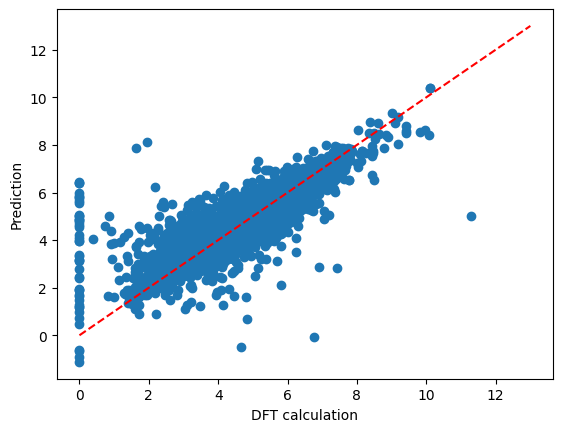

In [31]:
import matplotlib.pyplot as plt

outputs = model(X_test)
outputs = outputs[:,0]

preds = outputs.detach().numpy()
y_true = y_test.detach().numpy()

plt.scatter(y_true, preds)
plt.plot(range(0,14,1), range(0,14,1), 'r--')

plt.xlabel('DFT calculation')
plt.ylabel('Prediction');

In [32]:
import numpy as np
np.corrcoef(y_true, preds)

array([[1.        , 0.90649224],
       [0.90649224, 1.        ]])